## Imports

In [77]:
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import json
import copy
from plotly.subplots import make_subplots
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize
from datetime import datetime
from collections import Counter

In [111]:
data = json.load(open('research/output/youtube_data.json'))
channels = json.load(open('research/output/channels.json'))

## Processing

In [112]:
persuasions = ["Social Identity", "Concreteness", "Anchoring and Comparison", "Overcoming Reactance", "Reciprocity",
"Foot in the Door", "Authority", "Social Impact", "Anthropomorphism", "Scarcity", "Social Proof", "Unclear"]
sector_list = {"Technology": "#19A7CE", 
               "Media": "#F24C3D", 
               "Retailing and Apparel": "#F2BE22", 
               "Finance": "#00DFA2", 
               "Food and Household": "#F97B22", 
               "Wholesalers, Industrials and Energy": "#77037B", 
               "Transportation": "#413543",
               "Aerospace and Defence": "#090580",
               "Healthcare": "#FFACAC"}
year_list = ["Before 2014", '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']

In [113]:
frequency = {}
for video, values in data.items():
    for i, strat in enumerate(values["annots"]):
        if strat not in frequency:
            frequency[strat] = {"overall":0}
        frequency[strat]["overall"] += 1

In [114]:
companies = {}
for video, values in data.items():
    company = values["channelTitle"]
    if company not in companies:
        companies[company] = {"count":0, "videos":{}}
    y = values["publishedAt"][0:4]
    if int(y) <= 2013:
        y = "Before 2014"
    companies[company]["count"] += 1
    companies[company]["videos"][video] = {"annots":values["annots"], "publishedIn": y, "likeCount": values["likeCount"], "publishedAt":values["publishedAt"], "publishedIn": y,
                                         "viewCount":values["viewCount"], "sector": values["sector"], "videoTag":"video "+str(companies[company]["count"]), "commentCount":values["commentCount"]}
companies = dict(sorted(companies.items(), key=lambda item: item[0]))

In [115]:
for company in companies:
    companies[company]["subscriberCount"] = channels[company]["subscriberCount"]
    companies[company]["channelViewCount"] = channels[company]["channelViewCount"]    

In [116]:
top_5_companies = sorted(companies.items(), key=lambda x: x[1]["count"], reverse=True)[:5]
top_5_company_names = [company[0] for company in top_5_companies]

In [117]:
df = pd.DataFrame.from_dict(frequency).T

In [118]:
sectors = {}
for sector in sector_list:
    sectors[sector] = {"count":0, "num_companies":0, "videos":{}}

for video, values in data.items():
    sec = values["sector"]
    company = values["channelTitle"]
    for sector in sectors:
        if sec in sector:
            y = values["publishedAt"][0:4]
            if int(y) <= 2013:
                y = "Before 2014"
            sectors[sector]["count"] += 1
            sectors[sector]["videos"][video] = {"annots":values["annots"], "commentCount": values['commentCount'], "channelTitle":company, "publishedAt": values["publishedAt"], "publishedIn": y, "likeCount": values["likeCount"],
                                                 "viewCount":values["viewCount"], "videoTag":"video "+str(companies[company]["count"])}

In [119]:
sector_list_org = {"Technology": {}, "Media": {}, "Retailing": {}, "Apparel": {}, "Finance": {}, "Food": {}, "Household": {}, 
               "Wholesalers": {}, "Industrials": {}, "Energy": {}, "Transportation": {}, "Aerospace and Defence": {}, "Healthcare": {}}
for video, values in data.items():
    sector = values["sector"]
    company = values["channelTitle"]
    if company not in sector_list_org:
        sector_list_org[values["sector"]][company] = 0

for sector in sector_list_org:
    sector_list_org[sector] = len(sector_list_org[sector])

In [120]:
for sector, vals in sectors.items():
    unique_comp = {}
    for _, content in vals["videos"].items():
        unique_comp[content["channelTitle"]] = 0
    vals["num_companies"] = len(unique_comp)

# Sector-wise

## Persuasion Strategies used within same sector

### Frequency of sectors

In [32]:
df_sectors_pers = {}
for sector, values in sectors.items():
    df_sectors_pers[sector] = {"freq":values["count"], "company_freq":values["num_companies"]}

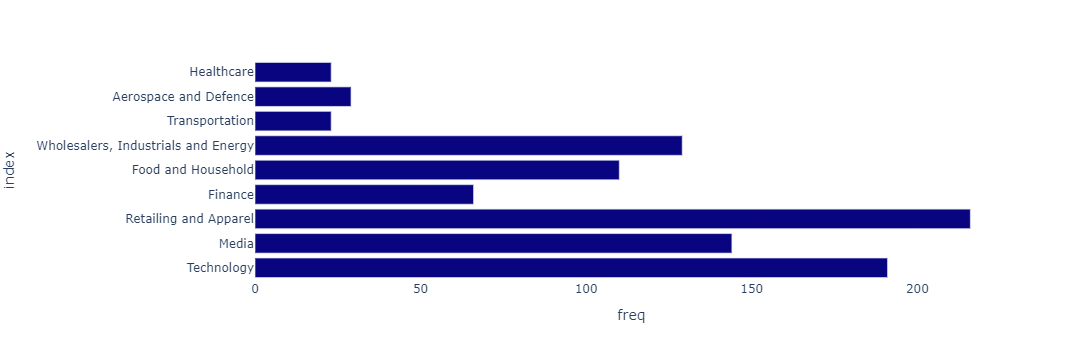

In [33]:
df_freq_sectors = pd.DataFrame.from_dict(df_sectors_pers).T
fig = px.bar(df_freq_sectors, x="freq", color_discrete_sequence=["#090580"])
fig.update_layout({
    "plot_bgcolor": "rgba(0,0,0,0)",
    "paper_bgcolor": "rgba(0,0,0,0)"
})
fig.show()
# plotly.offline.plot({"data": fig}, filename = "Frequency of sectors.html")

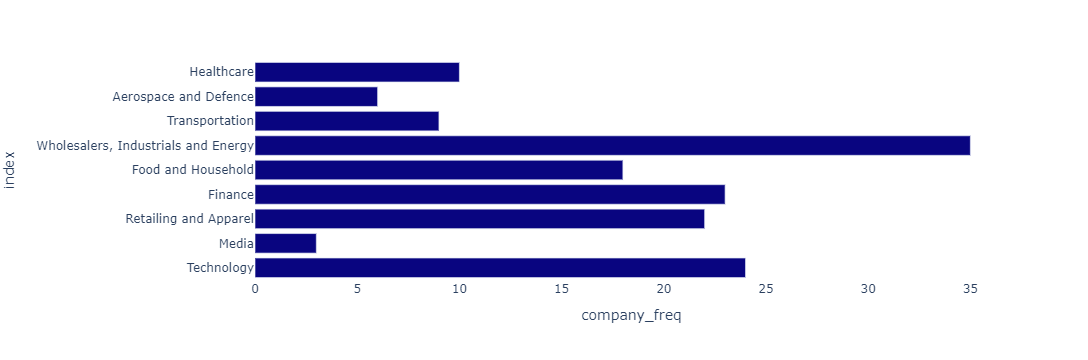

In [34]:
df_freq_sectors = pd.DataFrame.from_dict(df_sectors_pers).T
fig = px.bar(df_freq_sectors, x="company_freq", color_discrete_sequence=["#090580"])
fig.update_layout({
    "plot_bgcolor": "rgba(0,0,0,0)",
    "paper_bgcolor": "rgba(0,0,0,0)"
})
fig.show()

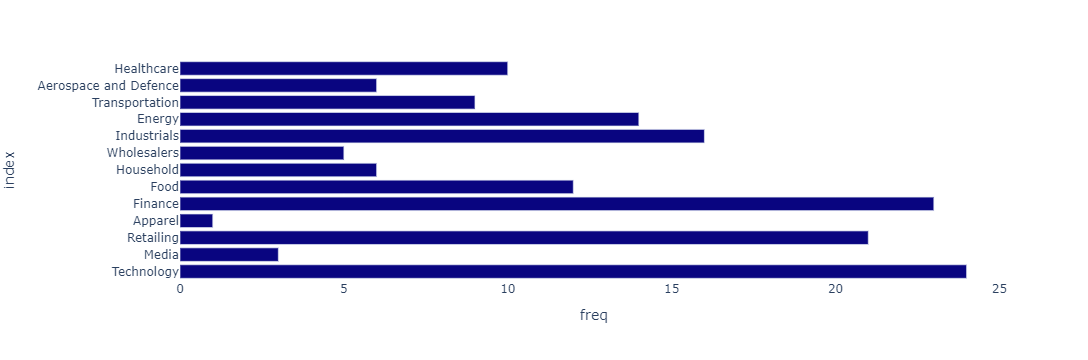

In [35]:
df_sectors_org = {}
for sector, values in sector_list_org.items():
    df_sectors_org[sector] = {"freq":values}

df_sectors_org = pd.DataFrame.from_dict(df_sectors_org).T
fig = px.bar(df_sectors_org, x="freq", color_discrete_sequence=["#090580"])
fig.update_layout({
    "plot_bgcolor": "rgba(0,0,0,0)",
    "paper_bgcolor": "rgba(0,0,0,0)"
})
fig.show()

### Sector vs Strategies

In [38]:
df_sectors_pers = {}
for sector in sectors:
    df_sectors_pers[sector] = {}
    for pers in persuasions:
        df_sectors_pers[sector][pers] = 0

for sector, values in sectors.items():
    for video, content in values['videos'].items():
        for strat in content["annots"]:
            df_sectors_pers[sector][strat] += 1

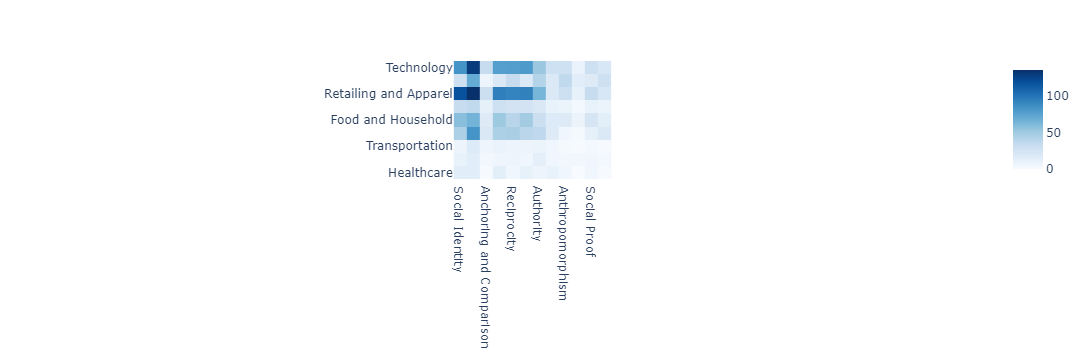

In [39]:
df_sectors_pers = pd.DataFrame.from_dict(df_sectors_pers).T
fig = px.imshow(df_sectors_pers, color_continuous_scale=px.colors.sequential.Blues)
fig.show()
# plotly.offline.plot({"data": fig}, filename = "Sector vs Strategies.html")

### Sector vs Strategies normalized

In [40]:
df_sectors_pers = df_sectors_pers.T.to_dict()
for sector, values in df_sectors_pers.items():
    total = sum(values.values())*len(sectors)
    for strat, value in values.items():
        df_sectors_pers[sector][strat] /= total

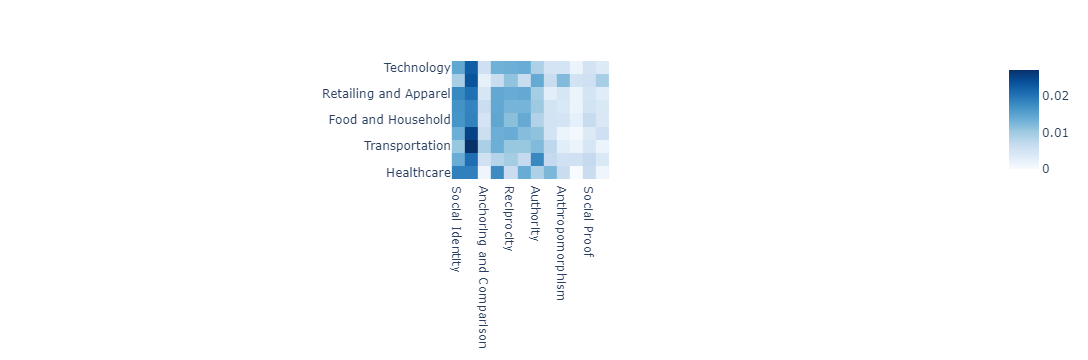

In [62]:
df_sectors_pers = pd.DataFrame.from_dict(df_sectors_pers).T
plt.figsize=(40, 40)
fig = px.imshow(df_sectors_pers, color_continuous_scale=px.colors.sequential.Blues)
fig.show()
# plotly.offline.plot({"data": fig}, filename = "Sector vs Strategies (normalized).html")

## Likes

In [67]:
df_sectors_pers_likes = {}
for sector in sectors:
    df_sectors_pers_likes[sector] = {}
    for pers in persuasions:
        df_sectors_pers_likes[sector][pers] = 0

for sector, values in sectors.items():
    for video, content in values['videos'].items():
        for strat in content["annots"]:
            df_sectors_pers_likes[sector][strat] += content['likeCount']/total_likes

### Normalized

In [68]:
df_sectors_pers_likes = {}
for sector in sectors:
    df_sectors_pers_likes[sector] = {}
    for pers in persuasions:
        df_sectors_pers_likes[sector][pers] = 0

for sector, values in sectors.items():
    total_likes = sum(content['likeCount'] for video, content in values['videos'].items())
    for video, content in values['videos'].items():
        for strat in content["annots"]:
            df_sectors_pers_likes[sector][strat] += content['likeCount']/total_likes

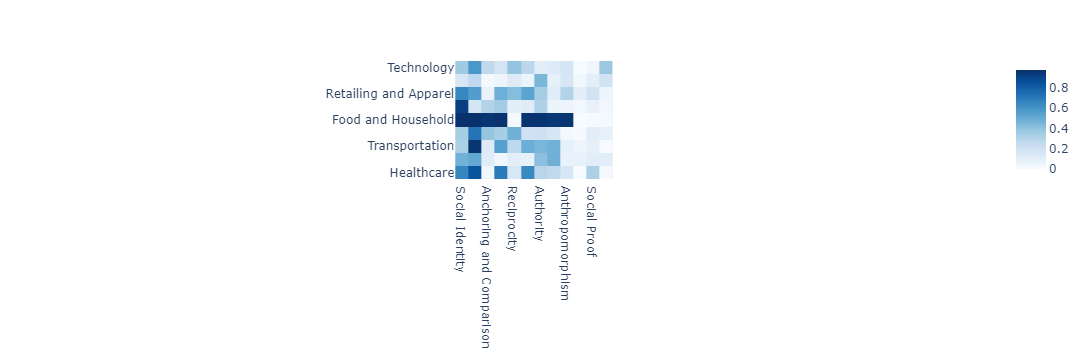

In [69]:
df_sectors_pers_likes = pd.DataFrame.from_dict(df_sectors_pers_likes).T
fig = px.imshow(df_sectors_pers_likes, color_continuous_scale=px.colors.sequential.Blues)
fig.show()

## Comments

In [103]:
df_sectors_pers_comments = {}
for sector in sectors:
    df_sectors_pers_comments[sector] = {}
    for pers in persuasions:
        df_sectors_pers_comments[sector][pers] = 0

for sector, values in sectors.items():
    for video, content in values['videos'].items():
        for strat in content["annots"]:
            df_sectors_pers_comments[sector][strat] += content['commentCount']

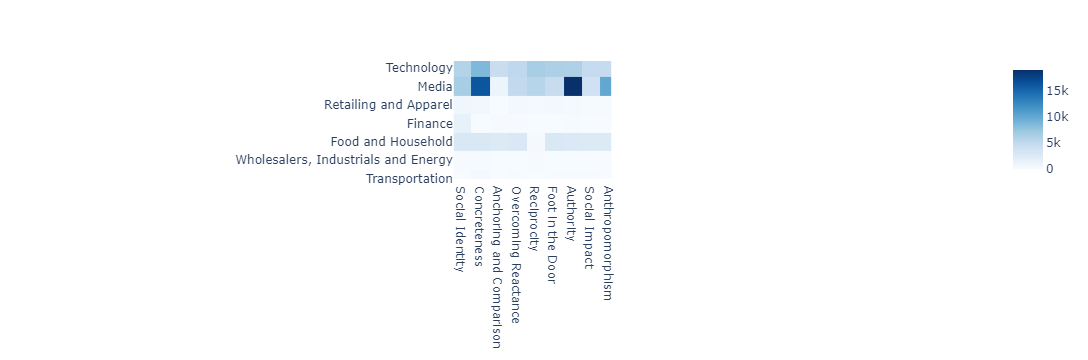

In [104]:
df_sectors_pers_comments = pd.DataFrame.from_dict(df_sectors_pers_comments).T
fig = px.imshow(df_sectors_pers_comments, color_continuous_scale=px.colors.sequential.Blues)
fig.show()
# plotly.offline.plot({"data": fig}, filename = "Sector vs Strategies.html")

## Trend of strategies over the years in each sector

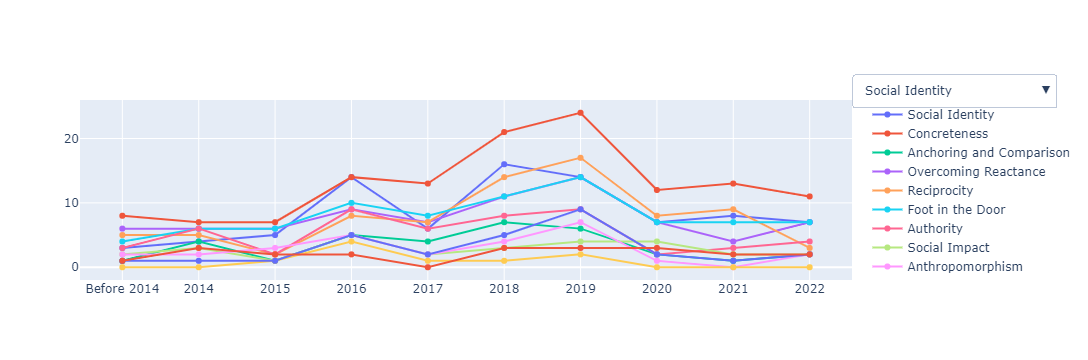

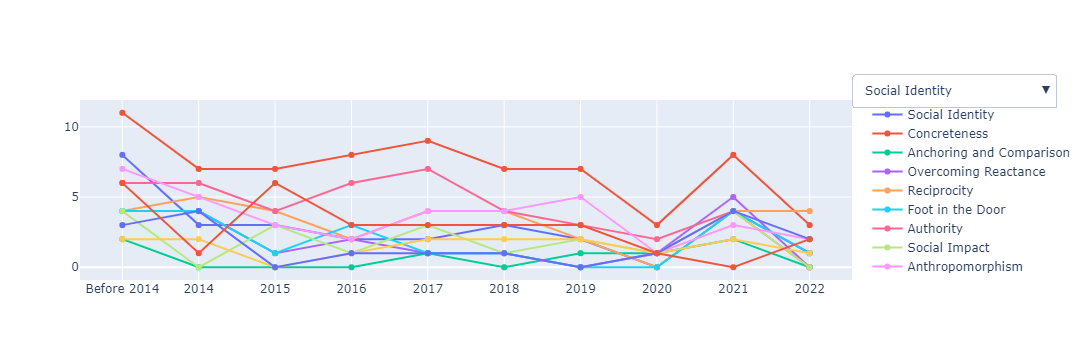

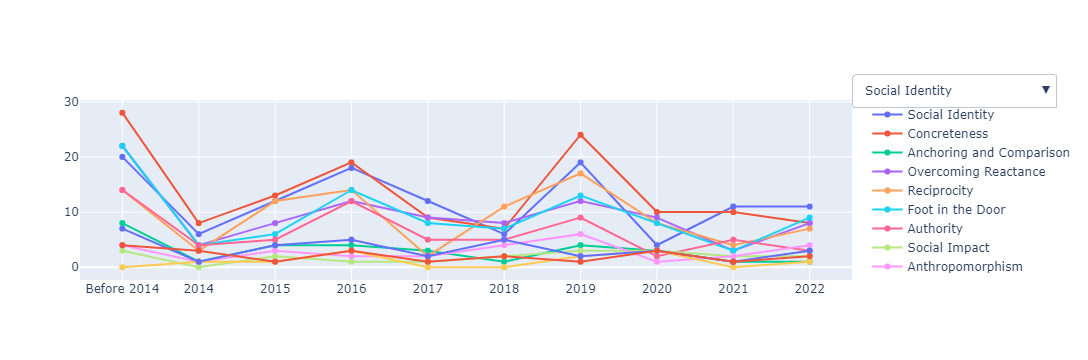

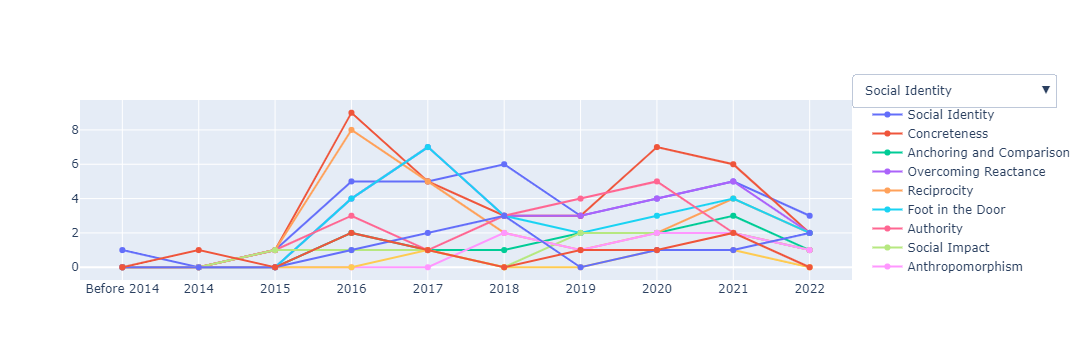

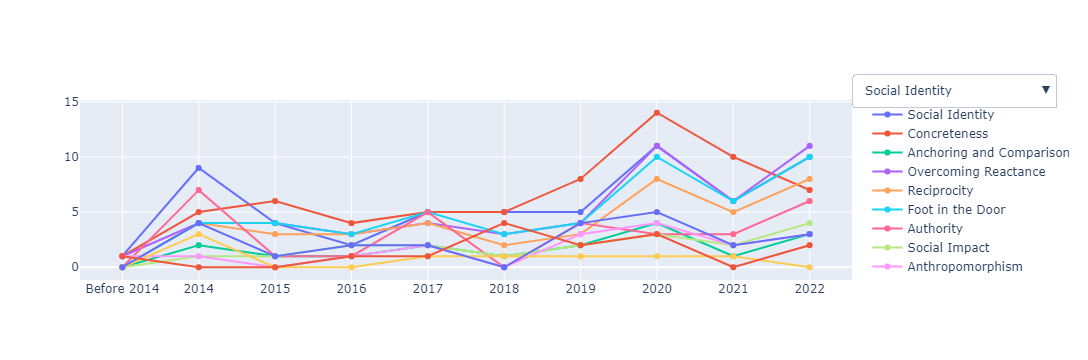

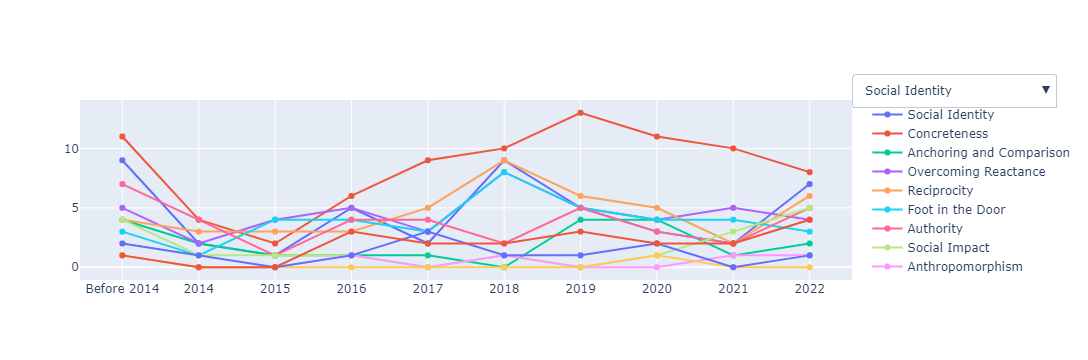

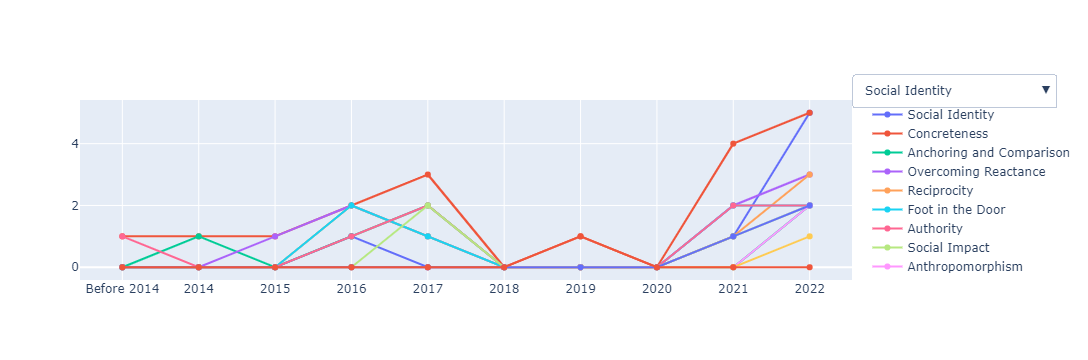

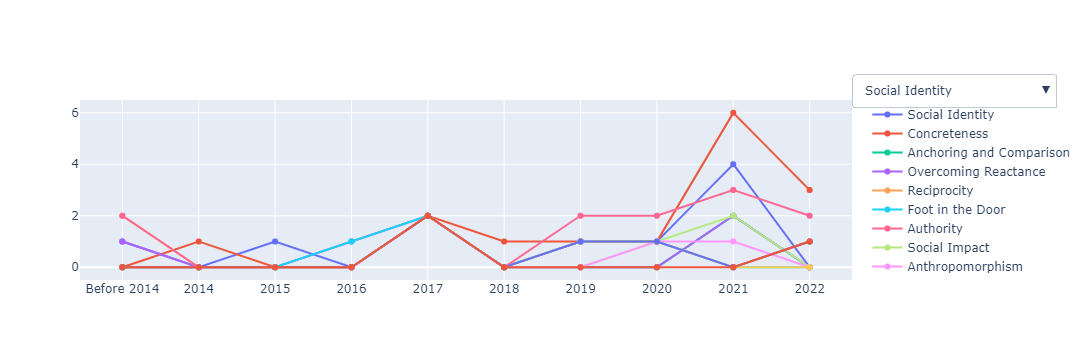

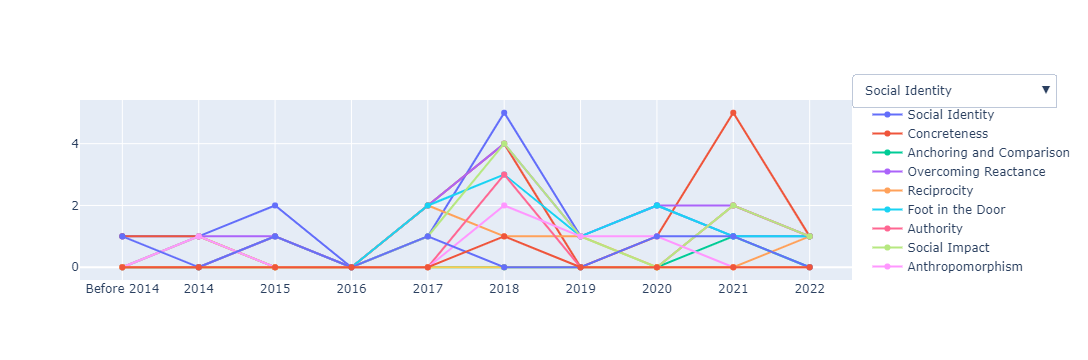

In [72]:
for sector, values in sectors.items():
    sector_years = {}
    for year in year_list:
        sector_years[year] = {}
        for pers in persuasions:
            sector_years[year][pers] = 0
    
    for video, content in values["videos"].items():
        year = content["publishedIn"]
        strats = content["annots"]
        for strat in strats:
            sector_years[year][strat] += 1
    
    year_values=[]
    for year, content in sector_years.items():
        buff = []
        for strat, value in content.items():
            buff.append(value)
        year_values.append(buff)
    year_values = np.transpose(year_values)
    
    buff_graphs = []
    plot_dicts = []
    
    for i, pers in enumerate(persuasions):
        visibility = [False]*len(persuasions)
        visibility[i] = True
        buff_graphs.append(go.Scatter(x=year_list, y=year_values[i], name=pers, line={ 'width': 2}))
        d = dict(args=[{"visible": visibility}, {"title": sector + " (" + str(values["count"]) + ")"}], 
             label=pers, method="update")
        plot_dicts.append(d)

    fig = go.Figure(data = buff_graphs)
    fig.update_layout(
        updatemenus=[
            dict(buttons= plot_dicts,
                          pad={"r": 10, "t": 10},
                          showactive=True,
                          x=1,
                          xanchor="left",
                          y=1.2,
                          yanchor="top")
        ]
    )
    fig.show()
#     plotly.offline.plot({"data": fig}, filename = "Trend of strategies over the years in " + sector + ".html")

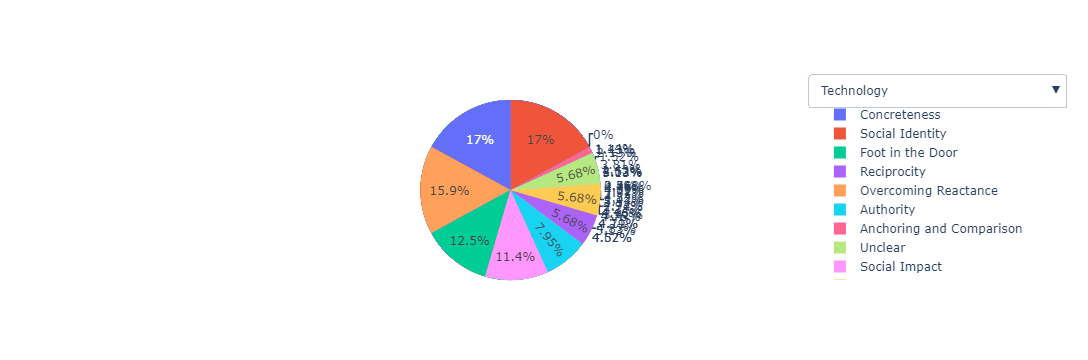

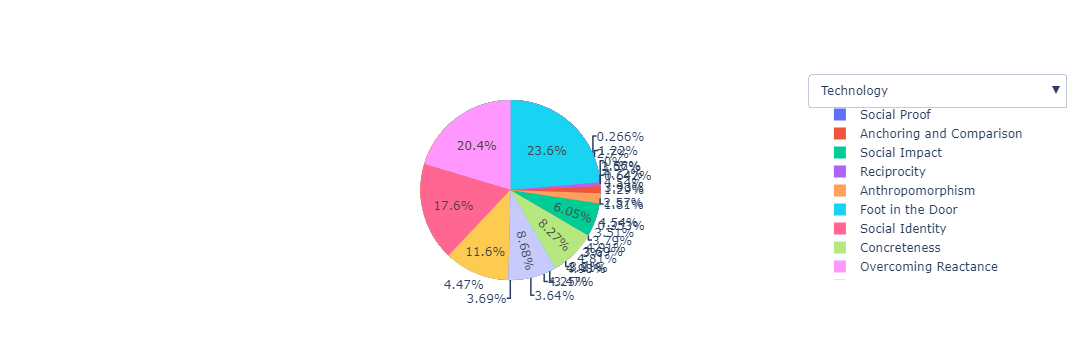

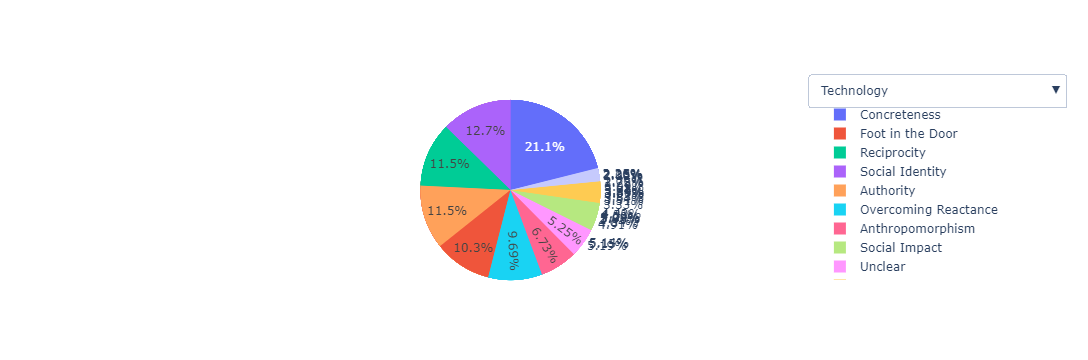

In [76]:
import plotly.graph_objects as go

graphs_frequency = []
graphs_outreach = []
graphs_engagement = []
num_sectors = len(sectors)
plot_dicts = []
j = 0

# New dictionary for video engagement
video_engagement = {}
for pers in persuasions:
    video_engagement[pers] = 0

for sector, content in sectors.items():
    sector_views = {}
    sector_likes = {}
    video_frequency = {}
    for pers in persuasions:
        sector_views[pers] = 0
        sector_likes[pers] = 0
        video_frequency[pers] = 0

    for video, values in content["videos"].items():
        strats = values["annots"]
        viewcount = values["viewCount"]
        likes = values["likeCount"]
        comments = values["commentCount"]

        for strat in strats:
            video_frequency[strat] += 1
            sector_views[strat] += viewcount
            sector_likes[strat] += likes
            video_engagement[strat] += (likes + comments) / viewcount if viewcount > 0 else 0

    # Calculate outreach (views/frequency) for each persuasion
    outreach = {pers: sector_views[pers] / video_frequency[pers] if video_frequency[pers] > 0 else 0 for pers in persuasions}

    # For frequency (number of videos)
    f = []
    for key in video_frequency:
        f.append(video_frequency[key])

    g = go.Pie(labels=strat_names, values=f, name="Frequency")
    graphs_frequency.append(g)

    # For outreach (views/frequency)
    o = []
    for key in outreach:
        o.append(outreach[key])

    g = go.Pie(labels=strat_names, values=o, name="Outreach")
    graphs_outreach.append(g)

    # For engagement ((likes + comments)/views)
    e = []
    for key in video_engagement:
        e.append(video_engagement[key])

    g = go.Pie(labels=strat_names, values=e, name="Engagement")
    graphs_engagement.append(g)

    visibility = [False] * num_sectors
    visibility[j] = True
    d = dict(args=[{"visible": visibility}, {"title": sector + " (" + str(content["count"]) + ")"}],
             label=sector, method="update")
    plot_dicts.append(d)
    j += 1

# Frequency figure
fig_frequency = go.Figure(data=graphs_frequency)
fig_frequency.update_layout(
    updatemenus=[dict(buttons=plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)
fig_frequency.show()

# Outreach figure
fig_outreach = go.Figure(data=graphs_outreach)
fig_outreach.update_layout(
    updatemenus=[dict(buttons=plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)
fig_outreach.show()

# Engagement figure
fig_engagement = go.Figure(data=graphs_engagement)
fig_engagement.update_layout(
    updatemenus=[dict(buttons=plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)
fig_engagement.show()


In [121]:
sectors = set()
fig_dict = {}
dataframes_by_sector = {}

for company, content in companies.items():
    for video, values in content["videos"].items():
        sector = values["sector"]
        sectors.add(sector)

for sector in sectors:
    strategies_data = {strat: 0 for strat in persuasions}

    for company, content in companies.items():
        for video, values in content["videos"].items():
            strats = values["annots"]
            views = values["viewCount"]
            subscribers = companies[company]["subscriberCount"]
            viewsBySubscribers = views / subscribers
            video_sector = values["sector"]
            date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")

            if video_sector == sector:
                for strat in strats:
                    strategies_data[strat] += viewsBySubscribers

    # Get the top strategies with the most views for the current sector
    top_strategies = [strat for strat in Counter(strategies_data).most_common(5)]

    # Initialize a new data structure for top strategies
    top_strategies_data = {strat: [] for strat in top_strategies}

    for company, content in companies.items():
        for video, values in content["videos"].items():
            strats = values["annots"]
            views = values["viewCount"]
            video_sector = values["sector"]
            subscribers = companies[company]["subscriberCount"]
            date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")

            if video_sector == sector:
                for strat in strats:
                    if strat in top_strategies:
                        top_strategies_data[strat].append({"Date": date, "Views": views})

    # Create a separate figure for the current sector
    fig = make_subplots(rows=1, cols=1)

    # Add traces for each top strategy in the current sector
    for strat, data in top_strategies_data.items():
        df = pd.DataFrame(data)
        df = df.set_index('Date').resample('M').sum()
        fig.add_trace(go.Scatter(x=df.index, y=df['ViewsBySubscribers'], mode="lines", name=strat))

    # Update the layout and labels for the current sector
    fig.update_layout(
        xaxis_title="Date",
        yaxis_title="Views",
        title=f"Top Strategies Monthly View Counts - Sector: {sector}",
    )

    # Store the figure in a dictionary
    fig_dict[sector] = fig

    # Store the data in a DataFrame
    df_sector = pd.concat([pd.DataFrame(data) for data in top_strategies_data.values()], axis=0)
    dataframes_by_sector[sector] = df_sector

# Show all figures for each sector
for sector, fig in fig_dict.items():
    fig.show()

KeyError: "None of ['Date'] are in the columns"

## Snakey

In [92]:
sector_strategy_data = {}

for sector, values in sectors.items():
    sector_strategy_data[sector] = {}
    for video, content in values["videos"].items():
        for strategy in content["annots"]:
            if strategy not in sector_strategy_data[sector]:
                sector_strategy_data[sector][strategy] = 1
            else:
                sector_strategy_data[sector][strategy] += 1

strategy_season_data = {}

for sector, values in sectors.items():
    for video, content in values["videos"].items():
        date = datetime.strptime(content["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")
        month = date.month
        season = month_to_season[month]
        for strategy in content["annots"]:
            if strategy not in strategy_season_data:
                strategy_season_data[strategy] = {season: 1}
            else:
                if season in strategy_season_data[strategy]:
                    strategy_season_data[strategy][season] += 1
                else:
                    strategy_season_data[strategy][season] = 1

In [97]:
print(sector_strategy_data['Technology'].get('Concreteness'))

130


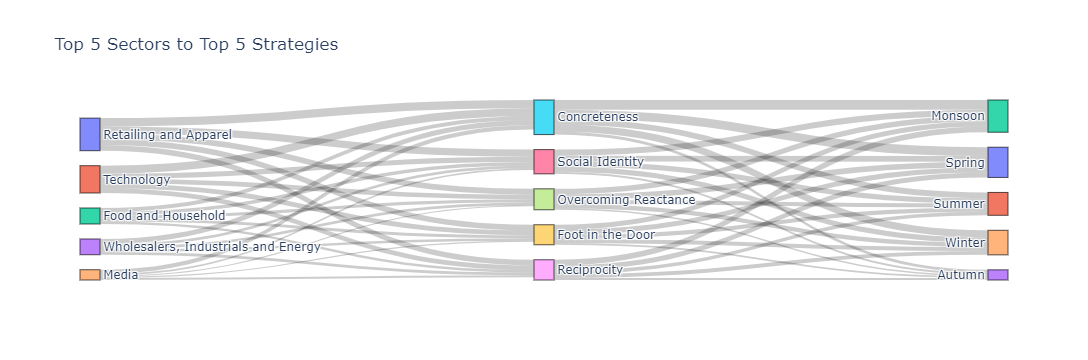

In [132]:
import plotly.graph_objs as go

def get_top_n_items(dictionary, n):
    return dict(sorted(dictionary.items(), key=lambda item: sum(item[1].values()), reverse=True)[:n])

# Select the top 5 sectors and top 5 strategies
top_sectors = get_top_n_items(sector_strategy_data, 5)
top_strategies = get_top_n_items(strategy_season_data, 5)

nodes = []
all_seasons = ["Spring", "Summer", "Monsoon", "Autumn", "Winter"]

# Create a mapping from labels to indices
label_to_index = {}

for sector in top_sectors:
    label_to_index[sector] = len(nodes)  # Assign the current index
    nodes.append(sector)  # Add the label

for strategy in top_strategies:
    label_to_index[strategy] = len(nodes)  # Assign the current index
    nodes.append(strategy)  # Add the label
    
for season in all_seasons:
    label_to_index[season] = len(nodes)  # Assign the current index
    nodes.append(season)  # Add the label

# Create links between sectors, strategies, and seasons with values representing frequency
links = []

for sector in top_sectors:
    sector_index = label_to_index[sector]  # Retrieve the index from the mapping
    for strategy in top_strategies:
        strategy_index = label_to_index[strategy]  # Retrieve the index from the mapping
        total_frequency = sector_strategy_data.get(sector, {}).get(strategy, {})
        links.append(dict(
            source=sector_index,
            target=strategy_index,
            value=total_frequency
        ))
        
for strategy in top_strategies:
    strategy_index = label_to_index[strategy]  # Retrieve the index from the mapping
    for season in all_seasons:  # Assuming you have a list of all seasons
        season_index = label_to_index[season]
        season_frequency = strategy_season_data.get(strategy, {}).get(season, 0)
        links.append(dict(
            source=strategy_index,
            target=season_index,
            value=season_frequency
        ))

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,  # Add the labels for sectors and strategies
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links]
    )
)])

# Plot the Sankey diagram
fig.update_layout(title_text="Top 5 Sectors to Top 5 Strategies")
fig.show()

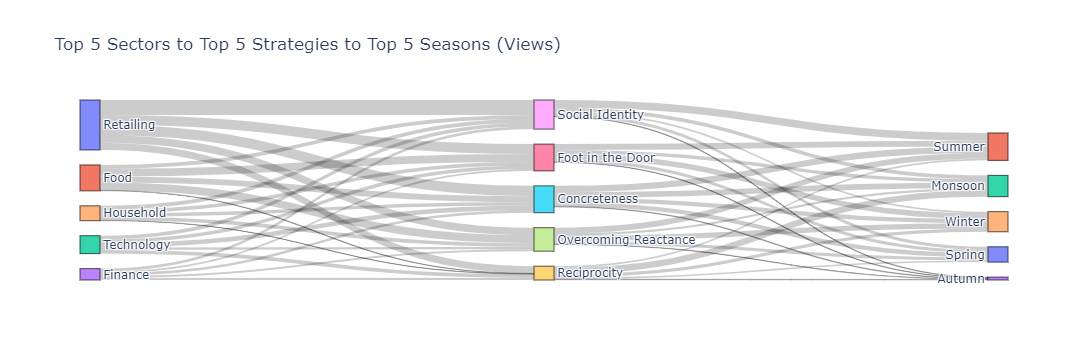

In [159]:
import plotly.graph_objs as go
from datetime import datetime

# Initialize dictionaries to store view counts for sectors, strategies, and seasons
sector_strategy_views = {}
sector_strategy_season_views = {}

# Loop through the data and calculate view counts
for video, values in data.items():
    sec = values["sector"]
    for strategy in values["annots"]:
        # Calculate season based on publishedAt
        date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")
        month = date.month
        season = month_to_season[month]

        # Update sector_strategy_views
        if sec not in sector_strategy_views:
            sector_strategy_views[sec] = {}
        else:
            if strategy not in sector_strategy_views[sec]:
                sector_strategy_views[sec][strategy] = 0
                sector_strategy_season_views[strategy] = {} 
            else:    
                if season not in sector_strategy_season_views[strategy]:
                    sector_strategy_season_views[strategy][season] = 0
                else:
                    sector_strategy_season_views[strategy][season] += values["viewCount"]
                sector_strategy_views[sec][strategy] += values["viewCount"]

def get_top_n_items(dictionary, n):
    
    return dict(sorted(dictionary.items(), key=lambda item: sum(item[1].values()), reverse=True)[:n])

# Select the top 5 sectors, strategies, and seasons
top_sectors = get_top_n_items(sector_strategy_views, 5)
top_strategies = get_top_n_items(sector_strategy_season_views, 5)
top_seasons = ["Spring", "Summer", "Monsoon", "Autumn", "Winter"]

nodes = []

# Create a mapping from labels to indices
label_to_index = {}

for sector in top_sectors:
    label_to_index[sector] = len(nodes)  # Assign the current index
    nodes.append(sector)  # Add the label

for strategy in top_strategies:
    label_to_index[strategy] = len(nodes)  # Assign the current index
    nodes.append(strategy)  # Add the label
    
for season in top_seasons:
    label_to_index[season] = len(nodes)  # Assign the current index
    nodes.append(season)  # Add the label

# Create links between sectors, strategies, and seasons with values representing views
links = []

for sector in top_sectors:
    sector_index = label_to_index[sector]  # Retrieve the index from the mapping
    for strategy in top_strategies:
        strategy_index = label_to_index[strategy]  # Retrieve the index from the mapping
        total_views = sector_strategy_views.get(sector, {}).get(strategy, 0)
        links.append(dict(
            source=sector_index,
            target=strategy_index,
            value=total_views
        ))

for strategy in top_strategies:
    strategy_index = label_to_index[strategy]  # Retrieve the index from the mapping
    for season in top_seasons:
        season_index = label_to_index[season]
        season_views = sector_strategy_season_views.get(strategy, {}).get(season, 0)
        links.append(dict(
            source=strategy_index,
            target=season_index,
            value=season_views
        ))

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes  # Add the labels for sectors, strategies, and seasons
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links]
    )
)])

# Plot the Sankey diagram
fig.update_layout(title_text="Top 5 Sectors to Top 5 Strategies to Top 5 Seasons (Views)")
fig.show()


In [166]:
print(sum(sector_strategy_season_views["Social Identity"].values()))
print(sector_strategy_season_views["Social Identity"])
print(sector_strategy_views["Retailing"]["Social Identity"])

112710860
{'Spring': 20880156, 'Autumn': 4471310, 'Summer': 50774497, 'Winter': 11695429, 'Monsoon': 24889468}
99976688


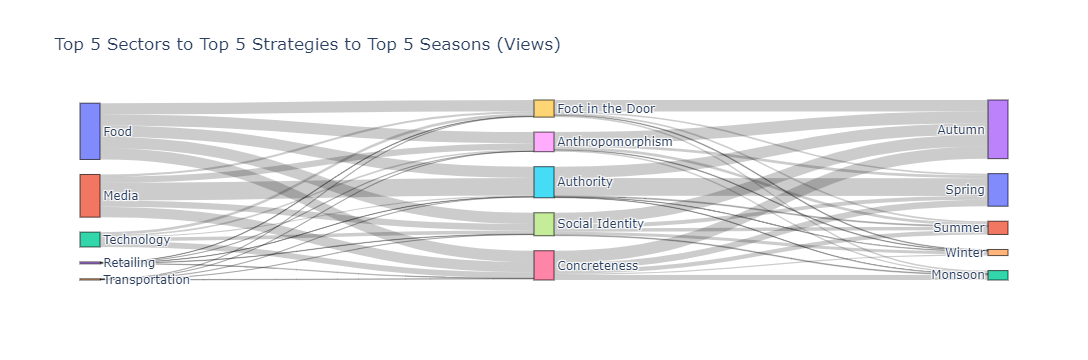

In [177]:
import plotly.graph_objs as go
from datetime import datetime

# Initialize dictionaries to store view counts for sectors, strategies, and seasons
sector_strategy_views = {}
sector_strategy_season_views = {}

# Loop through the data and calculate view counts
for video, values in data.items():
    sec = values["sector"]
    for strategy in values["annots"]:
        # Calculate season based on publishedAt
        date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")
        month = date.month
        season = month_to_season[month]

        # Update sector_strategy_views
        if sec not in sector_strategy_views:
            sector_strategy_views[sec] = {}
        if strategy not in sector_strategy_views[sec]:
            sector_strategy_views[sec][strategy] = 0
        sector_strategy_views[sec][strategy] += values["likeCount"]

        # Update sector_strategy_season_views
        if strategy not in sector_strategy_season_views:
            sector_strategy_season_views[strategy] = {}
        if season not in sector_strategy_season_views[strategy]:
            sector_strategy_season_views[strategy][season] = 0
        sector_strategy_season_views[strategy][season] += values["likeCount"]

# Select the top N sectors based on views
top_sectors = dict(sorted(sector_strategy_views.items(), key=lambda item: sum(item[1].values()), reverse=True)[:5])

# Select the top N strategies based on views and views by seasons
top_strategies = {}
for strategy, seasons in sector_strategy_season_views.items():
    total_views = sum(seasons.values())
    top_strategies[strategy] = {
        "total_views": total_views,
        "views_by_season": seasons
    }
top_strategies = dict(sorted(top_strategies.items(), key=lambda item: item[1]["total_views"], reverse=True)[:5])

# Select the top 5 seasons based on views
top_seasons = ["Spring", "Summer", "Monsoon", "Autumn", "Winter"]

nodes = []

# Create a mapping from labels to indices
label_to_index = {}

for sector in top_sectors:
    label_to_index[sector] = len(nodes)  # Assign the current index
    nodes.append(sector)  # Add the label

for strategy in top_strategies:
    label_to_index[strategy] = len(nodes)  # Assign the current index
    nodes.append(strategy)  # Add the label

for season in top_seasons:
    label_to_index[season] = len(nodes)  # Assign the current index
    nodes.append(season)  # Add the label

# Create links between sectors, strategies, and seasons with values representing views
links = []

for sector in top_sectors:
    sector_index = label_to_index[sector]  # Retrieve the index from the mapping
    for strategy in top_strategies:
        strategy_index = label_to_index[strategy]  # Retrieve the index from the mapping
        total_views = sector_strategy_views.get(sector, {}).get(strategy, 0)
        links.append(dict(
            source=sector_index,
            target=strategy_index,
            value=total_views
        ))

for strategy in top_strategies:
    strategy_index = label_to_index[strategy]  # Retrieve the index from the mapping
    for season in top_seasons:
        season_index = label_to_index[season]
        season_views = top_strategies[strategy]["views_by_season"].get(season, 0)
        links.append(dict(
            source=strategy_index,
            target=season_index,
            value=season_views
        ))

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes  # Add the labels for sectors, strategies, and seasons
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links]
    )
)])

# Plot the Sankey diagram
fig.update_layout(title_text="Top 5 Sectors to Top 5 Strategies to Top 5 Seasons (Likes)")
fig.show()


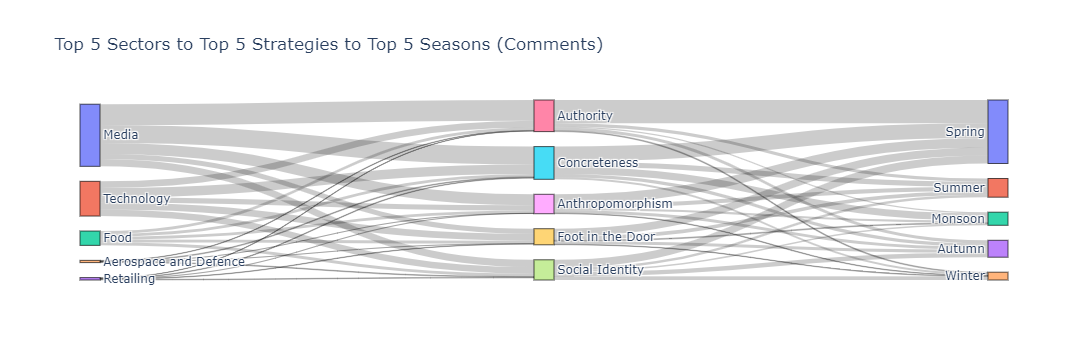

In [178]:
import plotly.graph_objs as go
from datetime import datetime

# Initialize dictionaries to store view counts for sectors, strategies, and seasons
sector_strategy_views = {}
sector_strategy_season_views = {}

# Loop through the data and calculate view counts
for video, values in data.items():
    sec = values["sector"]
    for strategy in values["annots"]:
        # Calculate season based on publishedAt
        date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")
        month = date.month
        season = month_to_season[month]

        # Update sector_strategy_views
        if sec not in sector_strategy_views:
            sector_strategy_views[sec] = {}
        if strategy not in sector_strategy_views[sec]:
            sector_strategy_views[sec][strategy] = 0
        sector_strategy_views[sec][strategy] += values["commentCount"]

        # Update sector_strategy_season_views
        if strategy not in sector_strategy_season_views:
            sector_strategy_season_views[strategy] = {}
        if season not in sector_strategy_season_views[strategy]:
            sector_strategy_season_views[strategy][season] = 0
        sector_strategy_season_views[strategy][season] += values["commentCount"]

# Select the top N sectors based on views
top_sectors = dict(sorted(sector_strategy_views.items(), key=lambda item: sum(item[1].values()), reverse=True)[:5])

# Select the top N strategies based on views and views by seasons
top_strategies = {}
for strategy, seasons in sector_strategy_season_views.items():
    total_views = sum(seasons.values())
    top_strategies[strategy] = {
        "total_views": total_views,
        "views_by_season": seasons
    }
top_strategies = dict(sorted(top_strategies.items(), key=lambda item: item[1]["total_views"], reverse=True)[:5])

# Select the top 5 seasons based on views
top_seasons = ["Spring", "Summer", "Monsoon", "Autumn", "Winter"]

nodes = []

# Create a mapping from labels to indices
label_to_index = {}

for sector in top_sectors:
    label_to_index[sector] = len(nodes)  # Assign the current index
    nodes.append(sector)  # Add the label

for strategy in top_strategies:
    label_to_index[strategy] = len(nodes)  # Assign the current index
    nodes.append(strategy)  # Add the label

for season in top_seasons:
    label_to_index[season] = len(nodes)  # Assign the current index
    nodes.append(season)  # Add the label

# Create links between sectors, strategies, and seasons with values representing views
links = []

for sector in top_sectors:
    sector_index = label_to_index[sector]  # Retrieve the index from the mapping
    for strategy in top_strategies:
        strategy_index = label_to_index[strategy]  # Retrieve the index from the mapping
        total_views = sector_strategy_views.get(sector, {}).get(strategy, 0)
        links.append(dict(
            source=sector_index,
            target=strategy_index,
            value=total_views
        ))

for strategy in top_strategies:
    strategy_index = label_to_index[strategy]  # Retrieve the index from the mapping
    for season in top_seasons:
        season_index = label_to_index[season]
        season_views = top_strategies[strategy]["views_by_season"].get(season, 0)
        links.append(dict(
            source=strategy_index,
            target=season_index,
            value=season_views
        ))

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes  # Add the labels for sectors, strategies, and seasons
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links]
    )
)])

# Plot the Sankey diagram
fig.update_layout(title_text="Top 5 Sectors to Top 5 Strategies to Top 5 Seasons (Comments)")
fig.show()


## Market Basket Analysis

In [ ]:
!pip install mlxtend

In [179]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Convert the data into a binary format
def binarize_data(sectors, strategies):
    binary_data = []
    for sector, data in sectors.items():
        transaction = [1 if strategy in data["videos"] else 0 for strategy in strategies]
        binary_data.append(transaction)
    return binary_data

# Perform Apriori analysis
def perform_apriori(binary_data, min_support=0.1, min_confidence=0.5):
    df = pd.DataFrame(binary_data, columns=strategies)
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_confidence)
    return rules

# Example usage
binary_data = binarize_data(sectors, strategies)
rules = perform_apriori(binary_data, min_support=0.1, min_confidence=0.5)


ModuleNotFoundError: No module named 'mlxtend'